Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class). The formula is then,

$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$

where N is the number of animals in the test set, M is the number of outcomes, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in outcome \\(j\\) and 0 otherwise, and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to outcome \\(j\\).

The submitted probabilities for a given animal are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
#test_df = pd.read_csv("./input/test.csv")
train_df = pd.read_csv("./input/train.csv")
#sample_submission_df = pd.read_csv("./input/sample_submission.csv")

In [4]:
train_df.tail()

AnimalID  Name             DateTime OutcomeType OutcomeSubtype  \
26724  A702446   NaN  2015-05-14 11:56:00    Transfer        Partner   
26725  A718934   NaN  2016-01-20 18:59:00    Transfer           SCRP   
26726  A698128  Zeus  2015-03-09 13:33:00    Adoption            NaN   
26727  A677478   NaN  2014-04-27 12:22:00    Transfer        Partner   
26728  A706629   NaN  2015-07-02 09:00:00    Transfer           SCRP   

      AnimalType SexuponOutcome AgeuponOutcome                    Breed  \
26724        Cat    Intact Male        1 month   Domestic Shorthair Mix   
26725        Cat  Spayed Female       3 months   Domestic Shorthair Mix   
26726        Dog  Neutered Male        4 years  Old English Bulldog Mix   
26727        Cat    Intact Male        4 weeks   Domestic Shorthair Mix   
26728        Cat    Intact Male         1 year   Domestic Shorthair Mix   

                   Color  
26724  Brown Tabby/White  
26725        Brown Tabby  
26726          White/Tan  
26727              Black  
26728  Brown Tabby/White

In [5]:
train_df.describe()

AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A453136    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824

In [6]:
train_df.keys()

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [7]:
train_df.shape

(26729, 10)

In [8]:
train_df["OutcomeType"].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [9]:
train_df["OutcomeSubtype"].value_counts()

Partner                7816
Foster                 1800
SCRP                   1599
Suffering              1002
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: OutcomeSubtype, dtype: int64

### Subtype 분류 유추  ( 이름, 성향(posi / neu / nega ), 의미유추 )
- Partner, p, 파트너에게 양도
- Foster, p, 일시적 양육 및 치료회복을 위한 제도  ->  모두 입양됨.
- SCRP, neu, stray cat return program 야생고양이 중성화 정책
- Suffering, n, 심함 고통중
- Aggressive, n, 공격적 성향
- Offsite, n, 시각장애
- Rabies Risk, n, 광견병 위험군


- In Kennel, neu, 장안에 따로 둠.
- Behavior, ?, 동물행동?
- Medical, neu, 병원 치료중
- In Foster, p, Foster 제도로 일시적 양육중.
- Enroute, neu, 이동중
- Court/Investigation, n, 재판 및 수사로 인해 보호중
- At Vet, neu, 수의사에게 있음
- In Surgery, neu, 수술 중
- Barn, neu?, 밖에서 키우는 중(?)

#### 추가 분석 요구됨

In [10]:
train_df["AnimalType"].value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [11]:
train_df["SexuponOutcome"].value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [12]:
train_df["AgeuponOutcome"].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
7 months      288
9 years       288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [13]:
train_df["Color"].value_counts()

Black/White                    2824
Black                          2292
Brown Tabby                    1635
Brown Tabby/White               940
White                           931
Brown/White                     884
Orange Tabby                    841
Tan/White                       773
Tricolor                        752
Blue/White                      702
Black/Tan                       672
White/Black                     643
Brown                           639
Tan                             628
White/Brown                     569
Tortie                          530
Calico                          517
Orange Tabby/White              455
Brown Brindle/White             450
Blue                            450
Black/Brown                     436
Blue Tabby                      433
White/Tan                       389
Red                             337
Torbie                          335
Brown/Black                     333
Red/White                       331
Blue Tabby/White            

    - 10개의 Column
        - AnimalID, Name, DateTime, OutcomeType, OutcomeSubtype, 
        - AnimalType, SexuponOutcome, AgeuponOutcome, Breed, Color
    1. 각 동물은 AnimalID 라는 고유의 값을 가짐
    2. Name에 NaN 값이 존재
    3. DateTime
    4. OutcomeType은 5가지
        - Adoption, Transfer, Return_to_owner, Euthanasia, Died
    5. OutcomeSubtype은 16가지
        - NaN 존재
    6. AnimalType은 2가지
        - Dog, Cat
    7. SexuponOutcome은 4가지
        - Neutered Male(중성화 수컷), Spayed Female(중성화 암컷), Intact Male(수컷), Intact Female(암컷)
    8. AgeuponOutcome은 매우 다양
    9. Breed(품종), 1380종
    10. Color
    
    
- 전처리 필요한 변수들
    - DateTime
    - AgeuponOutcome
        - 일수로 바꾸어 계산이 필요
    - Breed
        - 크기(소/중/대), 품종(순종/믹스), 장/단모 등
    - Color
        - Color별 분류 기준 수립 필요
        
        
    - \*SexuponOutcome
        - 중성화여부 (중성화 / 비중성화), 성별 (male, female)
        

- \*변수별 고려사항
    - Name: 이름 / NaN
    - DateTime: ?
    - OutcomeSubtype: ...
    - AnimalType: Dog & Cat (나눠서 볼것인가?)
    - SexuponOutcome: 중성화여부, 성별
    - AgeuponOutcome: 나이대별 categorization? & NaN 값 분석
    - Breed: ...
    - Color: ?

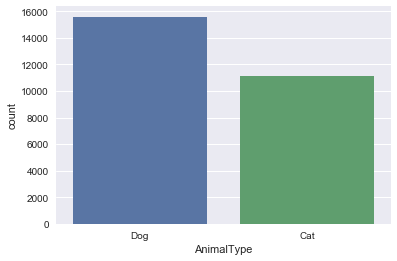

In [14]:
sns.countplot(train_df.AnimalType)

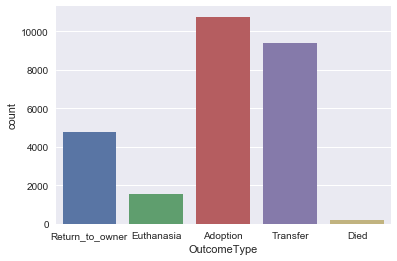

In [15]:
sns.countplot(train_df.OutcomeType)

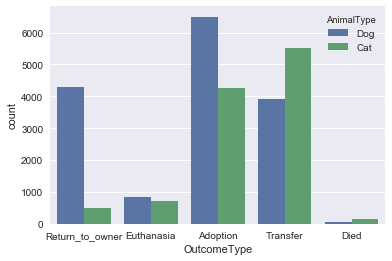

In [16]:
sns.countplot(train_df.OutcomeType, hue=train_df.AnimalType)

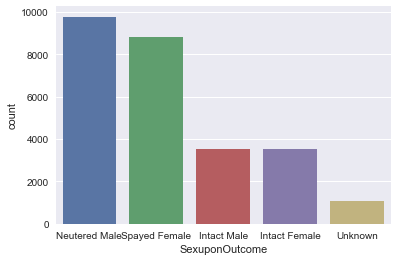

In [17]:
sns.countplot(train_df.SexuponOutcome)

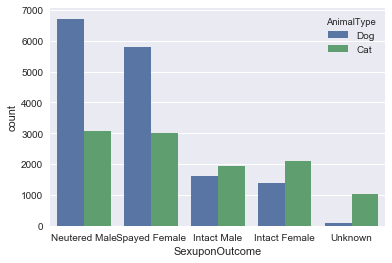

In [18]:
sns.countplot(train_df.SexuponOutcome, hue=train_df.AnimalType)

성별 column과 중성화 column 추가

In [19]:
# functions to get new parameters from the column
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'

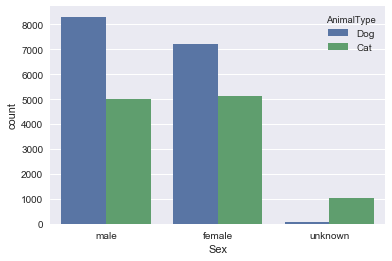

In [20]:
train_df['Sex'] = train_df.SexuponOutcome.apply(get_sex)
train_df['Neutered'] = train_df.SexuponOutcome.apply(get_neutered)
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(train_df.Sex, hue=train_df.AnimalType)

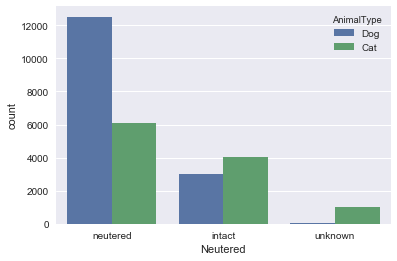

In [21]:
sns.countplot(train_df.Neutered, hue=train_df.AnimalType)

In [22]:
# 이름과 subtype 전처리
train_df['Name'] = train_df['Name'].replace(np.nan, 'Unknown', regex=True)
train_df['OutcomeSubtype'] = train_df['OutcomeSubtype'].replace(np.nan, 'None', regex=True)
train_df['AgeuponOutcome'] = train_df['AgeuponOutcome'].replace(np.nan, '0 days', regex=True)

In [23]:
# AgeuponOutcome -> 일수로 변경
for i in range(0, len(train_df['AgeuponOutcome'])):
    num, unit = (train_df['AgeuponOutcome'][i]).split(' ')
    if unit == 'year' or unit == 'years':
        train_df['AgeuponOutcome'][i] = int(num) * 365
    elif unit == 'month' or unit == 'months':
        train_df['AgeuponOutcome'][i] = int(num) * 30
    elif unit == 'week' or unit == 'weeks':
        train_df['AgeuponOutcome'][i] = int(num) * 7
    elif unit == 'day' or unit == 'days':
        train_df['AgeuponOutcome'][i] = int(num)

In [41]:
# AgeuponOutcome = NaN, 0 days 인 경우 분석
train_df[train_df['AgeuponOutcome'] == 0]

AnimalID     Name             DateTime OutcomeType OutcomeSubtype  \
280    A677462  Unknown  2014-04-25 15:17:00    Transfer        Partner   
1734   A699014  Unknown  2015-03-21 11:17:00  Euthanasia      Suffering   
2474   A678822  Unknown  2014-05-13 13:20:00    Transfer        Partner   
2480   A720674  Unknown  2016-02-16 10:17:00    Transfer           SCRP   
2912   A720973  Unknown  2016-02-18 19:07:00    Transfer           SCRP   
3195   A702176  Unknown  2015-05-10 18:36:00        Died      In Kennel   
3766   A720820  Unknown  2016-02-16 18:55:00    Transfer           SCRP   
3875   A721076  Unknown  2016-02-20 16:37:00  Euthanasia      Suffering   
4051   A677783  Unknown  2014-04-29 12:35:00    Transfer        Partner   
4209   A676306  Unknown  2014-04-07 18:59:00    Transfer        Partner   
4398   A666605  Unknown  2013-11-04 14:59:00    Transfer        Partner   
4498   A720422  Unknown  2016-02-09 19:43:00    Transfer           SCRP   
5137   A720697  Unknown  2016-02-16 10:17:00    Transfer           SCRP   
5256   A677465  Unknown  2014-04-25 15:18:00    Transfer        Partner   
5443   A678821  Unknown  2014-05-13 13:20:00    Transfer        Partner   
5691   A720640  Unknown  2016-02-16 10:17:00    Transfer           SCRP   
7005   A720636  Unknown  2016-02-16 10:17:00    Transfer           SCRP   
7609   A701723  Unknown  2015-05-03 17:28:00    Transfer        Partner   
8420   A720701  Unknown  2016-02-16 10:16:00    Transfer           SCRP   
9144   A710047  Unknown  2015-08-16 14:15:00    Transfer        Partner   
10699  A666602  Unknown  2013-11-04 14:55:00    Transfer        Partner   
12982  A666607  Unknown  2013-11-04 15:01:00    Transfer        Partner   
13108  A666600  Unknown  2013-11-04 14:54:00    Transfer        Partner   
15399  A666603  Unknown  2013-11-04 14:57:00    Transfer        Partner   
15605  A707429  Unknown  2015-07-13 09:26:00  Euthanasia      Suffering   
16745  A678820  Unknown  2014-05-13 13:20:00    Transfer        Partner   
17464  A720782  Unknown  2016-02-16 18:55:00    Transfer           SCRP   
18404  A676305  Unknown  2014-04-07 18:59:00    Transfer        Partner   
18490  A720780  Unknown  2016-02-16 18:54:00    Transfer           SCRP   
19203  A686911  Unknown  2014-08-28 18:20:00    Transfer        Partner   
19626  A666601  Unknown  2013-11-04 14:55:00    Transfer        Partner   
19927  A720653  Unknown  2016-02-16 10:16:00    Transfer           SCRP   
21523  A720652  Unknown  2016-02-16 10:16:00    Transfer           SCRP   
21891  A703214  Unknown  2015-05-21 18:24:00    Transfer        Partner   
22380  A720534  Unknown  2016-02-11 19:26:00    Transfer           SCRP   
22448  A720781  Unknown  2016-02-16 18:55:00    Transfer           SCRP   
22911  A710575  Unknown  2015-08-24 18:56:00    Transfer        Partner   
24328  A720908  Unknown  2016-02-17 15:07:00  Euthanasia      Suffering   
26551  A721113  Unknown  2016-02-21 18:22:00    Transfer           SCRP   
26570  A720502  Unknown  2016-02-10 18:49:00    Transfer           SCRP   

      AnimalType SexuponOutcome AgeuponOutcome                       Breed  \
280          Cat        Unknown              0      Domestic Shorthair Mix   
1734         Cat        Unknown              0      Domestic Shorthair Mix   
2474         Cat        Unknown              0      Domestic Shorthair Mix   
2480         Cat    Intact Male              0      Domestic Shorthair Mix   
2912         Cat        Unknown              0      Domestic Shorthair Mix   
3195         Cat  Intact Female              0       Domestic Longhair Mix   
3766         Cat  Intact Female              0      Domestic Shorthair Mix   
3875         Dog    Intact Male              0              Toy Poodle Mix   
4051         Cat        Unknown              0      Domestic Shorthair Mix   
4209         Cat  Intact Female              0      Domestic Shorthair Mix   
4398         Dog  Intact Female              0  Beagle/Chihuahua Shortha

AgeuponOutcome = NaN, 0 days 인 경우, 주요 특징 
    - AnimalType = cat   (dog 1마리 안락사)
    - Breed = Domestic Shorthair Mix  (cat 1마리 안락사는 longhair, dog 1마리 제외)
    - OutcomeSubtype = SCRP  ->  야생고양이  (안락사된 cat 1마리와 dog 1마리 제외)
    - OutcomeType = Transfer

## 이름 unknow 분석

In [25]:
train_df.shape

(26729, 12)

In [26]:
(train_df['Name'] == 'Unknown').value_counts()

False    19038
True      7691
Name: Name, dtype: int64

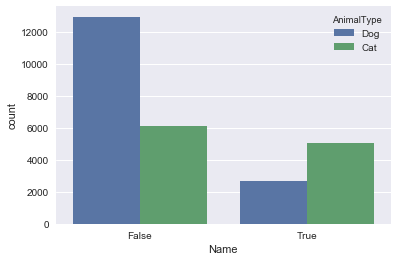

In [27]:
sns.countplot(train_df['Name'] == 'Unknown', hue=train_df.AnimalType)

In [28]:
train_df[train_df['Name'] == 'Unknown']

AnimalID     Name             DateTime OutcomeType OutcomeSubtype  \
3      A683430  Unknown  2014-07-11 19:09:00    Transfer        Partner   
4      A667013  Unknown  2013-11-15 12:52:00    Transfer        Partner   
7      A701489  Unknown  2015-04-30 17:02:00    Transfer        Partner   
9      A677747  Unknown  2014-05-03 07:48:00    Adoption        Offsite   
10     A668402  Unknown  2013-12-05 15:50:00    Transfer           SCRP   
11     A666320  Unknown  2013-11-04 14:48:00    Adoption           None   
16     A678050  Unknown  2014-05-03 16:15:00    Transfer        Partner   
17     A680028  Unknown  2014-06-07 12:54:00    Transfer        Partner   
30     A718535  Unknown  2016-01-01 13:57:00  Euthanasia      Suffering   
32     A682532  Unknown  2014-07-03 17:01:00    Adoption           None   
35     A668626  Unknown  2013-12-06 14:55:00  Euthanasia      Suffering   
37     A682413  Unknown  2014-07-02 13:37:00    Transfer        Partner   
39     A707503  Unknown  2015-07-14 12:16:00    Transfer        Partner   
41     A705598  Unknown  2015-06-23 13:25:00    Transfer        Partner   
43     A671181  Unknown  2014-01-21 15:15:00    Transfer           SCRP   
47     A701804  Unknown  2015-05-05 11:46:00    Transfer        Partner   
49     A666092  Unknown  2013-10-30 15:37:00  Euthanasia     Aggressive   
50     A684050  Unknown  2014-07-28 09:00:00    Transfer           SCRP   
52     A682347  Unknown  2014-06-26 17:16:00    Transfer        Partner   
55     A712979  Unknown  2015-10-04 15:02:00    Transfer        Partner   
57     A683443  Unknown  2014-07-18 16:23:00    Transfer        Partner   
64     A683961  Unknown  2014-07-17 17:31:00    Transfer        Partner   
68     A705258  Unknown  2015-06-16 09:00:00    Transfer           SCRP   
72     A674913  Unknown  2014-03-25 18:15:00    Adoption           None   
77     A675021  Unknown  2014-03-21 17:09:00  Euthanasia      Suffering   
79     A717839  Unknown  2015-12-20 19:38:00    Transfer           SCRP   
81     A712376  Unknown  2015-09-22 12:10:00  Euthanasia      Suffering   
83     A713690  Unknown  2015-10-12 09:00:00    Transfer           SCRP   
85     A687789  Unknown  2014-09-14 18:51:00    Adoption           None   
87     A707531  Unknown  2015-07-14 15:04:00    Transfer        Partner   
...        ...      ...                  ...         ...            ...   
26617  A720109  Unknown  2016-02-18 10:40:00  Euthanasia      Suffering   
26618  A680948  Unknown  2014-06-16 11:22:00    Adoption           None   
26621  A716882  Unknown  2015-11-29 18:45:00    Adoption           None   
26627  A714590  Unknown  2015-10-29 17:39:00    Adoption           None   
26631  A667859  Unknown  2013-11-26 14:58:00    Transfer           SCRP   
26636  A692850  Unknown  2014-11-27 09:00:00    Transfer           SCRP   
26640  A693023  Unknown  2014-12-01 09:00:00    Transfer           SCRP   
26647  A684346  Unknown  2014-07-22 16:04:00    Transfer        Partner   
26651  A710378  Unknown  2015-08-28 18:42:00    Adoption           None   
26659  A666377  Unknown  2013-10-31 12:50:00    Transfer        Partner   
26660  A694679  Unknown  2015-01-03 09:00:00    Transfer           SCRP   
26663  A674506  Unknown  2014-03-17 10:36:00  Euthanasia      Suffering   
26673  A676950  Unknown  2014-04-18 14:47:00    Transfer           SCRP   
26676  A689731  Unknown  2014-10-14 08:18:00  Euthanasia       Behavior   
26679  A667787  Unknown  2013-11-30 18:33:00    Transfer        Partner   
26682  A695546  Unknown  2015-01-18 09:00:00    Transfer           SCRP   
26683  A702863  Unknown  2015-05-19 09:00:00    Transfer           SCRP   
26687  A689726  Unknown  2014-10-13 18:26:00    Adoption           None   
26698  A678136  Unknown  2014-05-04 16:17:00    Transfer        Partner   
26702  A713637  Unknown  2015-10-11 09:42:00        Died      In Kennel   
26707  A682690  Unknown  2014-07-01 17:06:00  Euthanasia      Suffering   
26709  A714386  Unknown  2015-1

In [29]:
# Name 유무 변수 생성

def is_name(x):
    x = str(x)
    if x.find('Unknow') >= 0: return 0
    else: return 1

train_df['isName'] = train_df.Name.apply(is_name)

## plt 연습

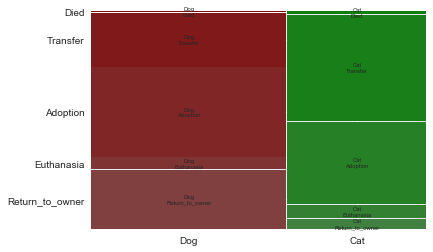

In [30]:
import statsmodels
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 7
mosaic = mosaic(train_df, ['AnimalType', 'OutcomeType'])

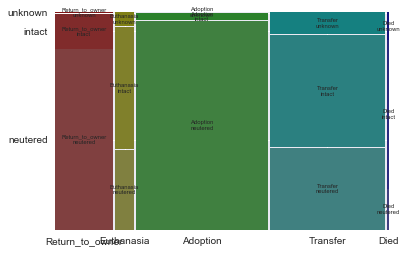

In [31]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 7
mosaic = mosaic(train_df, ['OutcomeType', 'Neutered'])

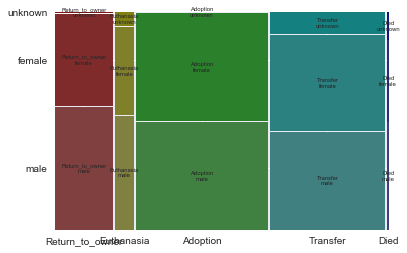

In [32]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 7
mosaic = mosaic(train_df, ['OutcomeType', 'Sex'])

In [ ]:
sns.violinplot(x="OutcomeType", y="AgebyDay", hue="AnimalType", data=train_df, split=True,
               inner="quart", palette={"Dog": "b", "Cat": "y"})

In [ ]:
sns.violinplot(x="Sex", y="AgeuponOutcome", hue="AnimalType", data=train_df, split=True,
               inner="quart", palette={"Dog": "b", "Cat": "y"})

In [ ]:
sns.violinplot(x="Neutered", y="AgeuponOutcome", hue="AnimalType", data=train_df, split=True,
               inner="quart", palette={"Dog": "b", "Cat": "y"})

## Color관련 분석

In [ ]:
train_df.OutcomeType.value_counts()

In [ ]:
print(train_df[train_df.OutcomeType == 'Adoption'].Color.value_counts().sum())
print(len(train_df[train_df.OutcomeType == 'Adoption'].Color.value_counts()))
train_df[train_df.OutcomeType == 'Adoption'].Color.value_counts()

In [ ]:
print(train_df[train_df.OutcomeType == 'Return_to_owner'].Color.value_counts().sum())
print(len(train_df[train_df.OutcomeType == 'Return_to_owner'].Color.value_counts()))
train_df[train_df.OutcomeType == 'Return_to_owner'].Color.value_counts()

In [ ]:
train_df[train_df.OutcomeType == 'Transfer'].Color.value_counts()

In [46]:
# Color 단순화 1단계 '/'제거
from pandas import Series
df2_c = train_df

bymain = []

for i in df2_c['Color']:
    i = str(i)
    if i.find('/') >= 0:
        f, s = i.split('/')
        bymain.append(f)
    else:
        bymain.append(i)

df2_c['newColor'] = Series(bymain)

In [47]:
print(df2_c[df2_c.OutcomeType == 'Adoption'].newColor.value_counts().sum())
print(len(df2_c[df2_c.OutcomeType == 'Adoption'].newColor.value_counts()))
df2_c[df2_c.OutcomeType == 'Adoption'].newColor.value_counts()

10769
54


Black              2581
White              1298
Brown Tabby         984
Brown               809
Tan                 722
Orange Tabby        513
Blue                454
Tricolor            354
Red                 305
Blue Tabby          278
Brown Brindle       276
Tortie              246
Calico              221
Chocolate           185
Sable               167
Torbie              161
Cream Tabby         123
Buff                120
Lynx Point           85
Blue Merle           81
Cream                79
Yellow               77
Gray                 74
Fawn                 69
Seal Point           64
Flame Point          43
Brown Merle          40
Black Smoke          39
Black Brindle        38
Blue Tick            24
Red Tick             23
Silver Tabby         22
Silver               21
Red Merle            21
Black Tabby          20
Gold                 20
Yellow Brindle       16
Lilac Point          15
Tortie Point         15
Chocolate Point      13
Blue Point           12
Calico Point    

In [ ]:
print(df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor.value_counts().sum())
print(len(df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor.value_counts()))
df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor.value_counts()

In [48]:
# Color 단순화 2단계 main color로 치환

def get_mainC(x):
    x = str(x)
    if x.find('Black') >= 0: return 'Black'
    if x.find('White') >= 0: return 'White'
    if x.find('Brown') >= 0: return 'Brown'
    if x.find('Orange') >= 0: return 'Orange'
    if x.find('Blue') >= 0: return 'Blue'
    if x.find('Red') >= 0: return 'Red'
    else: return x

df2_c['newColor2'] = df2_c.newColor.apply(get_mainC)

In [ ]:
print(df2_c[df2_c.OutcomeType == 'Adoption'].newColor2.value_counts().sum())
print(len(df2_c[df2_c.OutcomeType == 'Adoption'].newColor2.value_counts()))
df2_c[df2_c.OutcomeType == 'Adoption'].newColor2.value_counts()

In [ ]:
print(df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor2.value_counts().sum())
print(len(df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor2.value_counts()))
df2_c[df2_c.OutcomeType == 'Return_to_owner'].newColor2.value_counts()

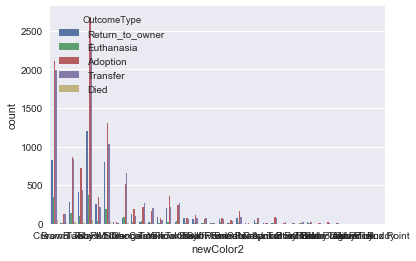

In [49]:
sns.countplot(train_df.newColor2, hue=train_df.OutcomeType)

## OutcomeSubtype분석

### Subtype 분석 결과 ( 이름, 의미 )
- OutcomeSubtype 은 OutcomeType 이전의 상태를 나타내는 것으로 보임.


- Partner, 파트너에게 양도  ->  모두 Transfer
- Foster, 일시적 양육 및 치료회복을 위한 제도  ->  모두 Adoption
- SCRP, stray cat return program 야생고양이 중성화 정책  ->  모두 Transfer, 모두 Cat
- Suffering, 심함 고통겪음  ->  모두 Euthanasia
- Aggressive, 공격적 성향  ->  모두 Euthanasia, 주로 Dog
- Offsite, 시각장애  ->  모두 Adoption
- Rabies Risk, 공수병 위험  ->  모두 Euthanasia


- In Kennel, 장안에 따로 둠.  ->  모두 Died
- Behavior, 동물행동장애  ->  모두 Euthanasia, 모두 Dog
- Medical, 병원 치료중  ->  모두 Euthanasia
- In Foster, Foster 제도로 일시적 양육했음.  ->  모두 Died (아마 치료 중 또는 노령 사망예상)
- Enroute, 이동했음.  ->  모두 Died (이송중 사망 또는 이송했으나 사망)
- Court/Investigation, 재판 및 수사로 인해 보호중   ->  모두 Euthanasia, 모두 Dog
- At Vet, 수의사에게 있었음  ->  모두 Died
- In Surgery, 수술 중  ->  모두 Died
- Barn, 밖에서 키우는 중(?)  ->  Transfer 1, Adoption 1. 모두 고양이

In [132]:
train_df.OutcomeSubtype.value_counts()

None                   13612
Partner                 7816
Foster                  1800
SCRP                    1599
Suffering               1002
Aggressive               320
Offsite                  165
In Kennel                114
Behavior                  86
Rabies Risk               74
Medical                   66
In Foster                 52
Enroute                    8
Court/Investigation        6
At Vet                     4
In Surgery                 3
Barn                       2
Name: OutcomeSubtype, dtype: int64

In [134]:
train_df[train_df.OutcomeSubtype == 'None'].tail()

AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
26717  A519949    Bella  2014-06-30 17:34:00  Return_to_owner           None   
26718  A701044  Unknown  2015-04-28 14:26:00         Adoption           None   
26720  A704405  Brownie  2015-07-18 14:08:00         Adoption           None   
26723  A716997     Zeus  2016-01-29 18:52:00         Adoption           None   
26726  A698128     Zeus  2015-03-09 13:33:00         Adoption           None   

      AnimalType SexuponOutcome AgeuponOutcome  \
26717        Dog  Spayed Female        9 years   
26718        Dog  Neutered Male       2 months   
26720        Cat  Spayed Female       2 months   
26723        Dog  Neutered Male        6 years   
26726        Dog  Neutered Male        4 years   

                                Breed           Color     Sex  Neutered  \
26717                 Bullmastiff Mix           Black  female  neutered   
26718  Siberian Husky/German Shepherd  Black/Tricolor    male  neutered   
26720          Domestic Shorthair Mix     Brown Tabby  female  neutered   
26723               Staffordshire Mix      Blue/White    male  neutered   
26726         Old English Bulldog Mix       White/Tan    male  neutered   

       AgebyDay  isName     newColor newColor2  
26717      3285       1        Black     Black  
26718        60       0        Black     Black  
26720        60       1  Brown Tabby     Brown  
26723      2190       1         Blue      Blue  
26726      1460       1        White     White

In [84]:
train_df[train_df.OutcomeSubtype == 'Partner']

AnimalID         Name             DateTime OutcomeType OutcomeSubtype  \
3      A683430      Unknown  2014-07-11 19:09:00    Transfer        Partner   
4      A667013      Unknown  2013-11-15 12:52:00    Transfer        Partner   
5      A677334         Elsa  2014-04-25 13:04:00    Transfer        Partner   
6      A699218        Jimmy  2015-03-28 13:11:00    Transfer        Partner   
7      A701489      Unknown  2015-04-30 17:02:00    Transfer        Partner   
16     A678050      Unknown  2014-05-03 16:15:00    Transfer        Partner   
17     A680028      Unknown  2014-06-07 12:54:00    Transfer        Partner   
18     A679010      Chrissy  2014-05-17 11:32:00    Transfer        Partner   
20     A670658       Anders  2014-01-19 15:03:00    Transfer        Partner   
21     A708812     Munchkin  2015-09-18 15:19:00    Transfer        Partner   
25     A712750        Olive  2015-10-03 15:44:00    Transfer        Partner   
31     A707341       Murphy  2015-07-15 15:25:00    Transfer        Partner   
34     A699723      Delgado  2015-04-11 16:01:00    Transfer        Partner   
37     A682413      Unknown  2014-07-02 13:37:00    Transfer        Partner   
38     A702655         Mica  2015-08-11 00:00:00    Transfer        Partner   
39     A707503      Unknown  2015-07-14 12:16:00    Transfer        Partner   
41     A705598      Unknown  2015-06-23 13:25:00    Transfer        Partner   
42     A668388         Lucy  2013-12-09 15:04:00    Transfer        Partner   
47     A701804      Unknown  2015-05-05 11:46:00    Transfer        Partner   
52     A682347      Unknown  2014-06-26 17:16:00    Transfer        Partner   
55     A712979      Unknown  2015-10-04 15:02:00    Transfer        Partner   
57     A683443      Unknown  2014-07-18 16:23:00    Transfer        Partner   
60     A709863  Orangejello  2015-08-19 13:32:00    Transfer        Partner   
62     A713029        Wilma  2015-10-06 15:07:00    Transfer        Partner   
64     A683961      Unknown  2014-07-17 17:31:00    Transfer        Partner   
66     A691847         Hero  2014-12-08 15:53:00    Transfer        Partner   
67     A711392        Molly  2015-09-08 15:31:00    Transfer        Partner   
71     A701575     Hastings  2016-01-29 14:53:00    Transfer        Partner   
75     A709371         Abby  2015-08-19 14:28:00    Transfer        Partner   
82     A703952         Taco  2015-05-30 18:56:00    Transfer        Partner   
...        ...          ...                  ...         ...            ...   
26582  A693929       Anakin  2014-12-23 14:55:00    Transfer        Partner   
26591  A706984          Moe  2015-07-20 14:56:00    Transfer        Partner   
26593  A715153      Unknown  2015-11-01 13:43:00    Transfer        Partner   
26596  A690218      Unknown  2014-10-24 11:37:00    Transfer        Partner   
26605  A695362      Sparkle  2015-01-21 15:48:00    Transfer        Partner   
26613  A680386       Monday  2014-06-15 15:50:00    Transfer        Partner   
26616  A696346    Valentine  2015-02-09 00:00:00    Transfer        Partner   
26632  A718851         June  2016-01-08 14:34:00    Transfer        Partner   
26638  A663735       Dakota  2013-10-20 13:12:00    Transfer        Partner   
26647  A684346      Unknown  2014-07-22 16:04:00    Transfer        Partner   
26652  A708843       Shania  2015-10-01 12:10:00    Transfer        Partner   
26657  A692415     Jeremiah  2015-01-14 17:40:00    Transfer        Partner   
26659  A666377      Unknown  2013-10-31 12:50:00    Transfer        Partner   
26670  A714656        Patsy  2015-11-15 14:38:00    Transfer        Partner   
26677  A704639     Smooshie  2015-06-30 12:13:00    Transfer        Partner   
26679  A667787      Unknown  2013-11-30 18:33:00    Transfer        Partner   
26685  A683216        Peggy  2014-07-30 13:46:00    Transfer        Partner   
26688  A670213         Izzy  2014-01-12 15:03:00    Transfer        Partner   
26690  A695801         Lola  2015-02-02 14:56:00    Tran

In [85]:
train_df[train_df.OutcomeSubtype == 'Partner'].OutcomeType.value_counts()

Transfer    7816
Name: OutcomeType, dtype: int64

In [90]:
train_df[train_df.OutcomeSubtype == 'Partner'].AnimalType.value_counts()

Dog    3911
Cat    3905
Name: AnimalType, dtype: int64

In [94]:
train_df[train_df.OutcomeSubtype == 'Partner'].isName.value_counts()

1    4436
0    3380
Name: isName, dtype: int64

In [87]:
train_df[train_df.OutcomeSubtype == 'Foster']

AnimalID          Name             DateTime OutcomeType OutcomeSubtype  \
2      A686464        Pearce  2015-01-31 12:28:00    Adoption         Foster   
12     A684601        Rocket  2016-02-03 11:27:00    Adoption         Foster   
15     A678825        Oliver  2014-07-12 12:10:00    Adoption         Foster   
80     A700740       Charlie  2015-12-17 12:10:00    Adoption         Foster   
86     A704754        Arthur  2015-07-18 15:37:00    Adoption         Foster   
94     A688443        Thelma  2014-12-29 15:11:00    Adoption         Foster   
139    A689601          Abby  2014-11-23 18:55:00    Adoption         Foster   
150    A707896         Tokyo  2016-02-19 14:58:00    Adoption         Foster   
159    A714069       Jupiter  2015-12-16 11:28:00    Adoption         Foster   
161    A717167         Oscar  2016-01-23 16:05:00    Adoption         Foster   
174    A701153       Unknown  2015-06-25 09:31:00    Adoption         Foster   
198    A676209        Boomer  2014-07-24 15:02:00    Adoption         Foster   
213    A687785         Bella  2014-12-30 09:38:00    Adoption         Foster   
222    A674737         Byron  2014-05-27 08:21:00    Adoption         Foster   
224    A676626           Pia  2014-05-30 16:54:00    Adoption         Foster   
235    A680336         Buddy  2014-07-12 20:04:00    Adoption         Foster   
263    A701791         Arwen  2015-07-19 14:37:00    Adoption         Foster   
284    A710881          Ruth  2015-10-14 10:12:00    Adoption         Foster   
305    A685145         Mundy  2014-09-13 14:10:00    Adoption         Foster   
315    A703630       Sheldon  2015-06-30 07:01:00    Adoption         Foster   
328    A697892         Bella  2015-03-16 17:38:00    Adoption         Foster   
338    A668803      Dumpling  2014-01-11 17:42:00    Adoption         Foster   
346    A701793       Unknown  2015-07-16 11:09:00    Adoption         Foster   
348    A711494       Celeste  2015-12-24 10:12:00    Adoption         Foster   
359    A695950        Laurel  2015-02-13 14:49:00    Adoption         Foster   
408    A681576        Pippin  2014-07-07 16:52:00    Adoption         Foster   
425    A682833          Nala  2014-09-13 18:35:00    Adoption         Foster   
434    A676270       Unknown  2014-07-12 17:18:00    Adoption         Foster   
452    A705109       Unknown  2015-06-29 17:44:00    Adoption         Foster   
461    A682724        Morris  2014-07-13 19:37:00    Adoption         Foster   
...        ...           ...                  ...         ...            ...   
26195  A687306        Sienna  2015-02-12 09:07:00    Adoption         Foster   
26209  A714193      Samantha  2015-11-30 17:16:00    Adoption         Foster   
26245  A431615        Catera  2014-08-01 07:51:00    Adoption         Foster   
26267  A664037     Halloween  2013-12-23 18:07:00    Adoption         Foster   
26283  A684344  Baby Princes  2014-08-30 15:39:00    Adoption         Foster   
26301  A701108          Milo  2015-07-16 10:26:00    Adoption         Foster   
26316  A690318         Trudy  2015-11-15 17:46:00    Adoption         Foster   
26335  A707293          Coco  2015-08-14 13:30:00    Adoption         Foster   
26338  A690209        Oliver  2014-12-26 14:22:00    Adoption         Foster   
26343  A713800        Peanut  2015-11-12 10:04:00    Adoption         Foster   
26345  A705925        Caesar  2015-07-27 15:47:00    Adoption         Foster   
26371  A680578          Ruby  2014-07-24 08:15:00    Adoption         Foster   
26378  A664743        Shadow  2013-12-04 11:57:00    Adoption         Foster   
26381  A703095  Uh-Oh Calico  2015-07-18 18:28:00    Adoption         Foster   
26393  A651686       Biscuit  2015-02-28 12:01:00    Adoption         Foster   
26433  A684406         Spots  2014-11-15 14:12:00    Adoption         Foster   
26453  A698924       Kit Cat  2015-04-06 14:05:00    Adoption         Foster   
26466  A681966         Maple  2014-08-13 16:31:00    Adoption         Foster   
26468 

In [88]:
train_df[train_df.OutcomeSubtype == 'Foster'].OutcomeType.value_counts()

Adoption    1800
Name: OutcomeType, dtype: int64

In [91]:
train_df[train_df.OutcomeSubtype == 'Foster'].AnimalType.value_counts()

Cat    1095
Dog     705
Name: AnimalType, dtype: int64

In [93]:
train_df[train_df.OutcomeSubtype == 'Foster'].isName.value_counts()

1    1542
0     258
Name: isName, dtype: int64

In [76]:
train_df[train_df.OutcomeSubtype == 'SCRP']

AnimalID     Name             DateTime OutcomeType OutcomeSubtype  \
10     A668402  Unknown  2013-12-05 15:50:00    Transfer           SCRP   
43     A671181  Unknown  2014-01-21 15:15:00    Transfer           SCRP   
50     A684050  Unknown  2014-07-28 09:00:00    Transfer           SCRP   
68     A705258  Unknown  2015-06-16 09:00:00    Transfer           SCRP   
79     A717839  Unknown  2015-12-20 19:38:00    Transfer           SCRP   
83     A713690  Unknown  2015-10-12 09:00:00    Transfer           SCRP   
98     A690658  Unknown  2014-10-24 09:00:00    Transfer           SCRP   
127    A686520  Unknown  2014-08-24 09:00:00    Transfer           SCRP   
137    A681481  Unknown  2014-06-18 09:00:00    Transfer           SCRP   
138    A714177  Unknown  2015-10-20 09:00:00    Transfer           SCRP   
158    A688067  Unknown  2014-09-15 09:00:00    Transfer           SCRP   
170    A690519  Unknown  2014-10-23 09:00:00    Transfer           SCRP   
187    A664304  Unknown  2013-10-03 12:27:00    Transfer           SCRP   
200    A671105  Unknown  2014-01-21 15:20:00    Transfer           SCRP   
218    A698940  Unknown  2015-03-21 09:00:00    Transfer           SCRP   
233    A684709  Unknown  2014-07-28 09:00:00    Transfer           SCRP   
244    A676334  Unknown  2014-04-22 15:35:00    Transfer           SCRP   
256    A713337  Unknown  2015-10-06 09:00:00    Transfer           SCRP   
273    A669534  Unknown  2013-12-24 15:03:00    Transfer           SCRP   
281    A715761  Unknown  2015-11-10 09:00:00    Transfer           SCRP   
318    A664380  Unknown  2013-10-03 15:33:00    Transfer           SCRP   
321    A693594  Unknown  2014-12-12 09:00:00    Transfer           SCRP   
339    A675983  Unknown  2014-04-03 15:19:00    Transfer           SCRP   
341    A667828  Unknown  2013-11-26 14:55:00    Transfer           SCRP   
345    A720143  Unknown  2016-02-08 19:23:00    Transfer           SCRP   
397    A719517  Unknown  2016-01-26 19:01:00    Transfer           SCRP   
417    A671682  Unknown  2014-01-30 13:14:00    Transfer           SCRP   
423    A681414  Unknown  2014-06-18 09:00:00    Transfer           SCRP   
459    A695428  Unknown  2015-01-16 09:00:00    Transfer           SCRP   
483    A690333  Unknown  2014-10-20 09:00:00    Transfer           SCRP   
...        ...      ...                  ...         ...            ...   
26376  A676392  Unknown  2014-04-10 14:34:00    Transfer           SCRP   
26380  A714591  Unknown  2015-10-26 09:00:00    Transfer           SCRP   
26430  A665020  Unknown  2013-10-13 15:24:00    Transfer           SCRP   
26436  A710693  Unknown  2015-08-27 09:00:00    Transfer           SCRP   
26479  A691439  Unknown  2014-11-05 09:00:00    Transfer           SCRP   
26485  A707816  Unknown  2015-07-19 09:00:00    Transfer           SCRP   
26514  A696599  Unknown  2015-02-09 09:00:00    Transfer           SCRP   
26520  A673510  Unknown  2014-02-26 15:05:00    Transfer           SCRP   
26540  A687017  Unknown  2014-08-31 09:00:00    Transfer           SCRP   
26549  A677711  Unknown  2014-04-29 15:25:00    Transfer           SCRP   
26551  A721113  Unknown  2016-02-21 18:22:00    Transfer           SCRP   
26559  A705030  Unknown  2015-06-13 09:00:00    Transfer           SCRP   
26561  A679576  Unknown  2014-05-24 17:33:00    Transfer           SCRP   
26570  A720502  Unknown  2016-02-10 18:49:00    Transfer           SCRP   
26577  A719098  Unknown  2016-01-20 18:58:00    Transfer           SCRP   
26588  A716029  Unknown  2015-11-17 19:06:00    Transfer           SCRP   
26601  A664612  Unknown  2013-10-06 17:48:00    Transfer           SCRP   
26603  A699170  Unknown  2015-03-24 09:00:00    Transfer           SCRP   
26614  A673841  Unknown  2014-03-04 14:06:00    Transfer           SCRP   
26631  A667859  Unknown  2013-11-26 14:58:00    Transfer           SCRP   
26636  A692850  Unknown  2014-11-27 09:00:00    Transfer           SCRP   
26640  A693023  Unknown  2014-1

In [80]:
train_df[train_df.OutcomeSubtype == 'SCRP'].OutcomeType.value_counts()

Transfer    1599
Name: OutcomeType, dtype: int64

In [78]:
train_df[train_df.OutcomeSubtype == 'SCRP'].AnimalType.value_counts()

Cat    1599
Name: AnimalType, dtype: int64

In [96]:
train_df[train_df.OutcomeSubtype == 'Suffering']

AnimalID          Name             DateTime OutcomeType OutcomeSubtype  \
1      A656520         Emily  2013-10-13 12:44:00  Euthanasia      Suffering   
30     A718535       Unknown  2016-01-01 13:57:00  Euthanasia      Suffering   
35     A668626       Unknown  2013-12-06 14:55:00  Euthanasia      Suffering   
61     A678506  Prec Punkin'  2014-05-09 18:07:00  Euthanasia      Suffering   
77     A675021       Unknown  2014-03-21 17:09:00  Euthanasia      Suffering   
81     A712376       Unknown  2015-09-22 12:10:00  Euthanasia      Suffering   
84     A691838       Avaddon  2015-02-09 17:17:00  Euthanasia      Suffering   
115    A695971       Unknown  2015-01-26 16:23:00  Euthanasia      Suffering   
123    A691968       Unknown  2014-11-14 11:57:00  Euthanasia      Suffering   
203    A702207       Unknown  2015-05-10 17:16:00  Euthanasia      Suffering   
246    A702356       Unknown  2015-05-24 17:25:00  Euthanasia      Suffering   
294    A689138       Unknown  2014-09-29 18:28:00  Euthanasia      Suffering   
295    A599155       Machete  2015-03-28 19:25:00  Euthanasia      Suffering   
362    A710227     Sebastian  2015-08-24 18:23:00  Euthanasia      Suffering   
395    A705656      Rasberry  2015-06-26 09:42:00  Euthanasia      Suffering   
416    A679631        Callie  2014-07-14 18:08:00  Euthanasia      Suffering   
418    A695654          Asha  2015-01-27 14:06:00  Euthanasia      Suffering   
419    A718566      Eleonora  2016-01-12 09:30:00  Euthanasia      Suffering   
449    A711562          Bino  2015-09-08 18:00:00  Euthanasia      Suffering   
474    A702756       Unknown  2015-05-17 19:03:00  Euthanasia      Suffering   
522    A700948       Unknown  2015-04-22 16:20:00  Euthanasia      Suffering   
525    A679167       Unknown  2014-05-17 11:10:00  Euthanasia      Suffering   
538    A665953       Unknown  2013-10-24 18:52:00  Euthanasia      Suffering   
539    A681155          Jeff  2014-12-11 17:07:00  Euthanasia      Suffering   
542    A685087       Unknown  2014-08-02 09:48:00  Euthanasia      Suffering   
562    A666083       Unknown  2013-10-26 16:41:00  Euthanasia      Suffering   
609    A664945       Unknown  2013-10-15 12:17:00  Euthanasia      Suffering   
625    A705433       Unknown  2015-06-22 16:18:00  Euthanasia      Suffering   
650    A674160           Mya  2014-03-28 17:42:00  Euthanasia      Suffering   
670    A694190      Lily Pad  2014-12-27 11:38:00  Euthanasia      Suffering   
...        ...           ...                  ...         ...            ...   
26083  A688907       Unknown  2014-09-26 10:33:00  Euthanasia      Suffering   
26087  A715687       Unknown  2015-11-08 12:43:00  Euthanasia      Suffering   
26147  A687699       Unknown  2014-09-10 07:42:00  Euthanasia      Suffering   
26188  A688003       Unknown  2014-09-14 09:34:00  Euthanasia      Suffering   
26192  A710885       Unknown  2015-09-03 15:26:00  Euthanasia      Suffering   
26227  A684266       Unknown  2014-07-21 15:10:00  Euthanasia      Suffering   
26243  A685670       Unknown  2014-08-11 10:16:00  Euthanasia      Suffering   
26253  A711756       Unknown  2015-09-11 18:20:00  Euthanasia      Suffering   
26255  A704465         Ennis  2015-06-11 14:43:00  Euthanasia      Suffering   
26275  A669461        Kahlua  2013-12-24 12:54:00  Euthanasia      Suffering   
26366  A682489       Unknown  2014-06-28 13:46:00  Euthanasia      Suffering   
26408  A693338       Unknown  2014-12-06 14:17:00  Euthanasia      Suffering   
26417  A666291       Unknown  2013-10-29 18:56:00  Euthanasia      Suffering   
26426  A695726       Unknown  2015-01-21 12:31:00  Euthanasia      Suffering   
26444  A696527       Unknown  2015-02-07 11:40:00  Euthanasia      Suffering   
26452  A665484       Unknown  2013-10-18 14:53:00  Euthanasia      Suffering   
26519  A680608       Unknown  2014-06-04 19:18:00  Euthanasia      Suffering   
26542  A714873       Unknown  2015-11-05 18:24:00  Euthanasia      Suffering   
26558 

In [97]:
train_df[train_df.OutcomeSubtype == 'Suffering'].OutcomeType.value_counts()

Euthanasia    1002
Name: OutcomeType, dtype: int64

In [98]:
train_df[train_df.OutcomeSubtype == 'Suffering'].AnimalType.value_counts()

Cat    652
Dog    350
Name: AnimalType, dtype: int64

In [99]:
train_df[train_df.OutcomeSubtype == 'Aggressive']

AnimalID        Name             DateTime OutcomeType OutcomeSubtype  \
49     A666092     Unknown  2013-10-30 15:37:00  Euthanasia     Aggressive   
93     A676680        Hero  2015-02-06 18:56:00  Euthanasia     Aggressive   
111    A657753         Wiz  2013-12-06 16:53:00  Euthanasia     Aggressive   
227    A487470    Midnight  2014-01-20 18:40:00  Euthanasia     Aggressive   
300    A674659     Unknown  2014-03-21 17:10:00  Euthanasia     Aggressive   
373    A678099   Spartacus  2015-06-10 17:23:00  Euthanasia     Aggressive   
385    A672744         Oso  2014-04-17 17:09:00  Euthanasia     Aggressive   
438    A663346        July  2013-11-10 18:25:00  Euthanasia     Aggressive   
589    A673275      Prince  2014-03-19 15:17:00  Euthanasia     Aggressive   
662    A690256        Mimi  2014-10-30 15:53:00  Euthanasia     Aggressive   
680    A654355        Kilo  2013-10-28 17:17:00  Euthanasia     Aggressive   
779    A679098        Lola  2015-03-16 13:06:00  Euthanasia     Aggressive   
805    A640789     Cupulin  2014-01-31 14:52:00  Euthanasia     Aggressive   
1304   A702705    Adrianna  2015-08-08 17:45:00  Euthanasia     Aggressive   
1328   A669934      Cookie  2014-01-07 15:37:00  Euthanasia     Aggressive   
1360   A651299       Fiona  2014-03-31 13:05:00  Euthanasia     Aggressive   
1539   A705299      Dexter  2015-11-26 09:33:00  Euthanasia     Aggressive   
1654   A690456      Bonnie  2014-10-24 15:26:00  Euthanasia     Aggressive   
1664   A698858         Zoe  2015-07-24 09:40:00  Euthanasia     Aggressive   
1731   A713622        Kiki  2015-12-01 14:44:00  Euthanasia     Aggressive   
1745   A666166       Elroy  2013-11-22 18:28:00  Euthanasia     Aggressive   
2031   A669485      Shades  2013-12-25 12:14:00  Euthanasia     Aggressive   
2047   A712059      Hector  2015-10-17 14:57:00  Euthanasia     Aggressive   
2093   A669133           Q  2014-03-11 14:12:00  Euthanasia     Aggressive   
2153   A672982        King  2014-03-27 13:52:00  Euthanasia     Aggressive   
2259   A687296     Unknown  2014-09-14 12:23:00  Euthanasia     Aggressive   
2268   A665281      Marley  2013-10-28 14:55:00  Euthanasia     Aggressive   
2415   A565312       Bella  2014-03-24 16:05:00  Euthanasia     Aggressive   
2553   A693989        Lobo  2016-01-16 15:51:00  Euthanasia     Aggressive   
2567   A701731      Buster  2015-05-07 08:24:00  Euthanasia     Aggressive   
...        ...         ...                  ...         ...            ...   
24436  A667300       Jones  2013-12-26 14:55:00  Euthanasia     Aggressive   
24495  A674472     Unknown  2014-03-17 12:50:00  Euthanasia     Aggressive   
24599  A669535     Malachi  2014-03-02 16:21:00  Euthanasia     Aggressive   
24640  A656968  Litle Girl  2013-11-11 15:13:00  Euthanasia     Aggressive   
24712  A704303        Koko  2015-06-09 16:49:00  Euthanasia     Aggressive   
24844  A527170       Olive  2015-01-27 11:56:00  Euthanasia     Aggressive   
24893  A713430         Leo  2015-10-24 12:53:00  Euthanasia     Aggressive   
25026  A694739      Johnny  2015-01-12 11:33:00  Euthanasia     Aggressive   
25054  A685760     Unknown  2014-08-20 15:41:00  Euthanasia     Aggressive   
25064  A704264      Sophie  2015-06-25 17:50:00  Euthanasia     Aggressive   
25272  A692449       Daisy  2015-02-12 08:58:00  Euthanasia     Aggressive   
25297  A671636       Rocky  2014-03-02 16:13:00  Euthanasia     Aggressive   
25428  A672128     Bentley  2014-02-14 10:58:00  Euthanasia     Aggressive   
25589  A647492     Bueller  2015-04-19 16:21:00  Euthanasia     Aggressive   
25667  A667363    Peluchin  2013-11-21 09:20:00  Euthanasia     Aggressive   
25699  A673466    Guinness  2015-10-08 15:22:00  Euthanasia     Aggressive   
25706  A630172       Hazel  2015-02-10 16:47:00  Euthanasia     Aggressive   
25810  A607543       Pitty  2014-08-06 17:54:00  Euthanasia     Aggressive   
25813  A547472      Guerra  2014-03-03 13:57:00  Euthanasia     Aggressive   
25890  A615008      Thauti  

In [100]:
train_df[train_df.OutcomeSubtype == 'Aggressive'].OutcomeType.value_counts()

Euthanasia    320
Name: OutcomeType, dtype: int64

In [101]:
train_df[train_df.OutcomeSubtype == 'Aggressive'].AnimalType.value_counts()

Dog    317
Cat      3
Name: AnimalType, dtype: int64

In [103]:
train_df[train_df.OutcomeSubtype == 'Offsite']

AnimalID          Name             DateTime OutcomeType OutcomeSubtype  \
9      A677747       Unknown  2014-05-03 07:48:00    Adoption        Offsite   
122    A688223       Unknown  2014-09-21 14:15:00    Adoption        Offsite   
141    A672453       Unknown  2014-02-16 19:38:00    Adoption        Offsite   
691    A676524    Chica Loca  2014-05-25 19:31:00    Adoption        Offsite   
946    A667606      Treasure  2014-01-19 16:47:00    Adoption        Offsite   
1023   A676272       Unknown  2014-06-01 16:09:00    Adoption        Offsite   
1088   A696866         Jewel  2015-02-21 16:49:00    Adoption        Offsite   
1204   A665072           Moe  2013-12-07 14:57:00    Adoption        Offsite   
1424   A661986        Smidge  2013-11-13 10:52:00    Adoption        Offsite   
1484   A682338          Toto  2014-08-02 20:05:00    Adoption        Offsite   
1529   A592335           Dex  2015-08-30 16:19:00    Adoption        Offsite   
1896   A672113        Mitten  2014-02-14 18:56:00    Adoption        Offsite   
2303   A708471        Peanut  2015-08-25 09:53:00    Adoption        Offsite   
2572   A677880     Christine  2014-05-03 07:35:00    Adoption        Offsite   
2574   A680312         Rolly  2014-08-10 17:17:00    Adoption        Offsite   
2641   A676639       Unknown  2014-04-23 11:13:00    Adoption        Offsite   
2696   A672402          Owen  2014-02-16 16:33:00    Adoption        Offsite   
2737   A675286        Zinnia  2014-04-06 17:03:00    Adoption        Offsite   
3076   A688273      Dutchess  2014-09-20 16:04:00    Adoption        Offsite   
3093   A689485       Sabrina  2014-12-06 15:13:00    Adoption        Offsite   
3274   A703805        Bitsie  2015-08-29 14:14:00    Adoption        Offsite   
3332   A701218           Pip  2015-05-03 19:32:00    Adoption        Offsite   
3391   A675194         Sunny  2014-03-29 17:11:00    Adoption        Offsite   
3673   A662776      Lil Baby  2013-11-06 09:15:00    Adoption        Offsite   
3748   A712449         Buffy  2015-09-27 13:18:00    Adoption        Offsite   
4069   A677881     Sweet Pea  2014-05-03 07:43:00    Adoption        Offsite   
4222   A700794       Valerie  2015-04-25 22:57:00    Adoption        Offsite   
4568   A695171        Dallas  2015-01-18 19:24:00    Adoption        Offsite   
4608   A698390        Dunkin  2015-04-25 22:49:00    Adoption        Offsite   
4642   A675845          Axel  2014-05-10 15:57:00    Adoption        Offsite   
...        ...           ...                  ...         ...            ...   
22001  A713195          Saya  2015-12-07 14:19:00    Adoption        Offsite   
22047  A662686       Davinci  2013-11-01 11:58:00    Adoption        Offsite   
22055  A667853         Gilly  2013-11-30 15:02:00    Adoption        Offsite   
22212  A687068       Frankie  2014-09-20 16:10:00    Adoption        Offsite   
22245  A692495   Little Mama  2015-08-29 14:04:00    Adoption        Offsite   
22267  A701007        Eloise  2015-05-03 19:35:00    Adoption        Offsite   
22486  A632012        Austin  2014-01-18 15:20:00    Adoption        Offsite   
22796  A695408       Unknown  2015-01-18 08:42:00    Adoption        Offsite   
23201  A698086         Ernie  2015-08-01 16:00:00    Adoption        Offsite   
23271  A672494         Katja  2014-02-16 19:15:00    Adoption        Offsite   
23341  A695239       Unknown  2015-01-17 20:18:00    Adoption        Offsite   
23500  A678195       Unknown  2014-05-11 17:30:00    Adoption        Offsite   
23718  A667777  Peanutbutter  2014-02-16 19:06:00    Adoption        Offsite   
24045  A712338          Noel  2015-09-27 12:36:00    Adoption        Offsite   
24170  A700597           Leo  2015-04-25 22:54:00    Adoption        Offsite   
24383  A671167          Milo  2014-02-16 16:33:00    Adoption        Offsite   
24466  A676275       Unknown  2014-06-22 17:52:00    Adoption        Offsite   
24751  A706332    Cottontail  2015-08-30 16:25:00    Adoption        Offsite   
24959 

In [104]:
train_df[train_df.OutcomeSubtype == 'Offsite'].OutcomeType.value_counts()

Adoption    165
Name: OutcomeType, dtype: int64

In [105]:
train_df[train_df.OutcomeSubtype == 'Offsite'].AnimalType.value_counts()

Dog    101
Cat     64
Name: AnimalType, dtype: int64

In [108]:
train_df[train_df.OutcomeSubtype == 'In Kennel']

AnimalID      Name             DateTime OutcomeType OutcomeSubtype  \
553    A705794     Logan  2015-07-01 09:38:00        Died      In Kennel   
931    A683992   Unknown  2014-07-22 11:30:00        Died      In Kennel   
2973   A665671   Unknown  2013-10-25 12:49:00        Died      In Kennel   
3195   A702176   Unknown  2015-05-10 18:36:00        Died      In Kennel   
4726   A646914    Jasper  2014-01-28 08:46:00        Died      In Kennel   
4731   A712576   Grayson  2015-10-08 11:43:00        Died      In Kennel   
5070   A709238     Penny  2015-08-15 08:06:00        Died      In Kennel   
5328   A670064   Unknown  2014-01-03 16:33:00        Died      In Kennel   
5585   A704522   Unknown  2015-06-11 08:21:00        Died      In Kennel   
5715   A693598   Unknown  2014-12-15 09:28:00        Died      In Kennel   
5879   A709074   Unknown  2015-08-07 08:17:00        Died      In Kennel   
5938   A677450     Gizmo  2014-05-22 18:32:00        Died      In Kennel   
6000   A678927   Unknown  2014-05-20 10:58:00        Died      In Kennel   
6031   A712572   Catfish  2015-09-28 14:33:00        Died      In Kennel   
6120   A718527   Unknown  2016-01-03 09:37:00        Died      In Kennel   
6284   A705793      Luis  2015-06-30 12:49:00        Died      In Kennel   
6434   A713937    Fisher  2016-02-09 08:00:00        Died      In Kennel   
6800   A706022  Mitchell  2015-07-08 09:26:00        Died      In Kennel   
7091   A683445     Blynn  2014-07-17 07:55:00        Died      In Kennel   
7183   A702160     Eagle  2015-05-31 16:37:00        Died      In Kennel   
7246   A704993      Kyra  2015-06-19 09:20:00        Died      In Kennel   
7269   A673972     Eddie  2014-03-10 17:30:00        Died      In Kennel   
7312   A710335    Rebbie  2015-09-05 08:45:00        Died      In Kennel   
7509   A719998    Bernie  2016-02-05 10:52:00        Died      In Kennel   
7843   A720680       Tho  2016-02-16 10:48:00        Died      In Kennel   
7938   A693387   Unknown  2014-12-15 09:27:00        Died      In Kennel   
8066   A666677       Max  2013-11-09 08:53:00        Died      In Kennel   
8319   A703793   Unknown  2015-06-08 12:07:00        Died      In Kennel   
8441   A664184   Unknown  2013-10-10 18:44:00        Died      In Kennel   
8570   A687558   Unknown  2014-09-29 18:15:00        Died      In Kennel   
...        ...       ...                  ...         ...            ...   
19636  A713643   Unknown  2015-10-11 17:40:00        Died      In Kennel   
19829  A664219   Unknown  2013-10-01 12:34:00        Died      In Kennel   
19994  A686619   Unknown  2014-09-29 18:09:00        Died      In Kennel   
20021  A714172   Unknown  2015-10-26 11:43:00        Died      In Kennel   
20252  A705161   Unknown  2015-06-15 15:47:00        Died      In Kennel   
20511  A717196   Unknown  2015-12-11 10:18:00        Died      In Kennel   
20717  A582433   Unknown  2015-03-28 08:35:00        Died      In Kennel   
20759  A714733   Unknown  2015-11-07 09:22:00        Died      In Kennel   
21039  A708801   Unknown  2015-08-03 14:26:00        Died      In Kennel   
21203  A713402   Unknown  2015-10-10 16:26:00        Died      In Kennel   
21783  A692531   Unknown  2014-11-26 12:38:00        Died      In Kennel   
21827  A705851    Debbie  2015-06-28 12:07:00        Died      In Kennel   
22536  A694468   Unknown  2014-12-31 08:39:00        Died      In Kennel   
22664  A661430  Choochoo  2013-10-06 12:15:00        Died      In Kennel   
22759  A705081   Unknown  2015-06-14 13:24:00        Died      In Kennel   
23195  A707677   Unknown  2015-07-16 08:37:00        Died      In Kennel   
23359  A704986    Prince  2015-06-20 17:17:00        Died      In Kennel   
23415  A704364      Owen  2015-06-18 09:08:00        Died      In Kennel   
23754  A688920   Unknown  2014-10-10 08:05:00        Died      In Kennel   
23874  A677289   Unknown  2014-04-28 11:20:00        Died      In Kennel   
24220  A664491   Unknown  2013-10-10 18:44:00        D

In [106]:
train_df[train_df.OutcomeSubtype == 'In Kennel'].OutcomeType.value_counts()

Died    114
Name: OutcomeType, dtype: int64

In [107]:
train_df[train_df.OutcomeSubtype == 'In Kennel'].AnimalType.value_counts()

Cat    84
Dog    30
Name: AnimalType, dtype: int64

In [110]:
train_df[train_df.OutcomeSubtype == 'Behavior']

AnimalID       Name             DateTime OutcomeType OutcomeSubtype  \
269    A683309    Unknown  2014-07-17 18:06:00  Euthanasia       Behavior   
621    A683654    Unknown  2014-07-19 10:46:00  Euthanasia       Behavior   
771    A694012      Zorro  2014-12-20 14:03:00  Euthanasia       Behavior   
850    A666197      Leroy  2013-12-19 11:08:00  Euthanasia       Behavior   
860    A665137     Willie  2013-11-15 14:52:00  Euthanasia       Behavior   
1170   A701910       Maia  2015-05-17 16:50:00  Euthanasia       Behavior   
1826   A662603     Tucker  2013-11-26 14:06:00  Euthanasia       Behavior   
2523   A698597     Thiago  2015-03-14 18:07:00  Euthanasia       Behavior   
2768   A666273    Jasmine  2013-11-29 11:12:00  Euthanasia       Behavior   
3604   A681431  Deltadawn  2014-06-22 16:46:00  Euthanasia       Behavior   
3773   A606120     Archie  2013-10-05 14:34:00  Euthanasia       Behavior   
4400   A663667       Cody  2013-10-17 15:33:00  Euthanasia       Behavior   
5145   A713954       Baby  2015-10-15 17:20:00  Euthanasia       Behavior   
5600   A694251    Unknown  2015-01-03 15:22:00  Euthanasia       Behavior   
6119   A668337       Tony  2014-01-01 13:42:00  Euthanasia       Behavior   
6869   A672745     Dottie  2014-02-25 11:41:00  Euthanasia       Behavior   
6918   A682726      Rocky  2014-07-03 12:41:00  Euthanasia       Behavior   
6969   A696683     Cooper  2015-02-12 18:18:00  Euthanasia       Behavior   
7134   A616456       Star  2014-09-18 10:43:00  Euthanasia       Behavior   
7145   A663158    Preston  2013-11-03 13:48:00  Euthanasia       Behavior   
7223   A689794       Lyle  2014-10-21 13:16:00  Euthanasia       Behavior   
7342   A693687      Major  2015-03-27 14:52:00  Euthanasia       Behavior   
7379   A690765  Magnum Pi  2014-11-07 17:34:00  Euthanasia       Behavior   
7440   A680780    Mei Mei  2014-09-03 17:55:00  Euthanasia       Behavior   
8589   A656477     Bowser  2014-03-27 14:03:00  Euthanasia       Behavior   
8761   A645673   Precious  2014-06-17 11:52:00  Euthanasia       Behavior   
8884   A674490   Princess  2014-06-26 14:08:00  Euthanasia       Behavior   
9092   A664027      Tessa  2013-10-10 12:04:00  Euthanasia       Behavior   
9459   A684862    Kennedy  2014-09-08 13:59:00  Euthanasia       Behavior   
9551   A690696       Leia  2014-11-10 10:01:00  Euthanasia       Behavior   
...        ...        ...                  ...         ...            ...   
18012  A672449    Unknown  2014-02-16 14:23:00  Euthanasia       Behavior   
18130  A664869      Ollie  2013-10-28 15:05:00  Euthanasia       Behavior   
18886  A669859       Mack  2014-01-08 16:10:00  Euthanasia       Behavior   
19588  A701001       Skit  2015-04-24 15:19:00  Euthanasia       Behavior   
20386  A665175       Stan  2013-12-27 18:24:00  Euthanasia       Behavior   
20503  A614177    Diamond  2013-11-26 14:12:00  Euthanasia       Behavior   
21342  A684752       Liam  2014-11-23 16:53:00  Euthanasia       Behavior   
21493  A686415       Kobi  2014-12-11 17:17:00  Euthanasia       Behavior   
22930  A673506     Briggs  2014-03-09 08:05:00  Euthanasia       Behavior   
22957  A673912     Edward  2014-03-19 15:16:00  Euthanasia       Behavior   
23070  A667976    Crystal  2013-12-19 12:02:00  Euthanasia       Behavior   
23105  A672210    Cochise  2014-02-20 14:50:00  Euthanasia       Behavior   
23141  A663273    Diamond  2014-01-01 13:44:00  Euthanasia       Behavior   
23227  A670631    Unknown  2014-01-18 16:00:00  Euthanasia       Behavior   
24362  A674455    Calypso  2014-03-22 16:39:00  Euthanasia       Behavior   
24662  A674708      Lucky  2015-04-22 11:08:00  Euthanasia       Behavior   
24821  A664608      Rosco  2013-10-28 17:44:00  Euthanasia       Behavior   
24888  A688309      Bambi  2014-10-01 18:42:00  Euthanasia       Behavior   
24988  A680527     Shadow  2014-07-02 14:26:00  Euthanasia       Behavior   
25063  A668495    Unknown  2013-12-11 17:41:00  Euthanasia       Behavior   
25

In [111]:
train_df[train_df.OutcomeSubtype == 'Behavior'].OutcomeType.value_counts()

Euthanasia    86
Name: OutcomeType, dtype: int64

In [112]:
train_df[train_df.OutcomeSubtype == 'Behavior'].AnimalType.value_counts()

Dog    86
Name: AnimalType, dtype: int64

In [113]:
train_df[train_df.OutcomeSubtype == 'Rabies Risk']

AnimalID        Name             DateTime OutcomeType OutcomeSubtype  \
457    A700335  Dorchester  2015-07-04 08:56:00  Euthanasia    Rabies Risk   
790    A670417        Spot  2014-01-11 09:46:00  Euthanasia    Rabies Risk   
829    A503376        Lobo  2015-12-08 11:41:00  Euthanasia    Rabies Risk   
1258   A669977       Zeppo  2014-04-01 15:44:00  Euthanasia    Rabies Risk   
1284   A667153     Unknown  2013-11-13 15:49:00  Euthanasia    Rabies Risk   
1877   A715302     Unknown  2015-11-03 15:05:00  Euthanasia    Rabies Risk   
2745   A710733     Unknown  2015-08-28 10:58:00  Euthanasia    Rabies Risk   
2995   A717038     Unknown  2015-12-03 08:00:00  Euthanasia    Rabies Risk   
3707   A677564     Unknown  2014-04-26 13:41:00  Euthanasia    Rabies Risk   
3740   A670085     Unknown  2014-01-05 10:41:00  Euthanasia    Rabies Risk   
3872   A720463     Unknown  2016-02-11 08:04:00  Euthanasia    Rabies Risk   
4197   A683619     Unknown  2014-07-15 08:28:00  Euthanasia    Rabies Risk   
4295   A716795     Unknown  2015-11-29 08:57:00  Euthanasia    Rabies Risk   
4570   A565221      Prieto  2014-09-29 08:55:00  Euthanasia    Rabies Risk   
5901   A713642     Unknown  2015-10-13 15:44:00  Euthanasia    Rabies Risk   
6113   A697142    Red Girl  2015-05-21 08:22:00  Euthanasia    Rabies Risk   
6134   A691355  Jonny Cash  2014-11-04 08:13:00  Euthanasia    Rabies Risk   
6360   A703795        Trax  2015-05-31 08:41:00  Euthanasia    Rabies Risk   
6484   A681593     Unknown  2014-06-19 08:22:00  Euthanasia    Rabies Risk   
6548   A620900     Roswell  2014-02-26 17:33:00  Euthanasia    Rabies Risk   
6815   A516260        Skye  2016-02-12 10:42:00  Euthanasia    Rabies Risk   
6989   A687866        Gray  2014-09-11 14:35:00  Euthanasia    Rabies Risk   
7983   A694880      Sallie  2015-04-19 16:11:00  Euthanasia    Rabies Risk   
8059   A676661      Callie  2014-04-14 12:02:00  Euthanasia    Rabies Risk   
8461   A707097        Lily  2015-07-10 08:03:00  Euthanasia    Rabies Risk   
10252  A464652       Buddy  2014-10-29 08:11:00  Euthanasia    Rabies Risk   
10403  A692274     Charlie  2014-11-20 08:07:00  Euthanasia    Rabies Risk   
10749  A616257     Grayson  2014-11-24 10:27:00  Euthanasia    Rabies Risk   
10861  A696004        Lucy  2015-01-28 10:39:00  Euthanasia    Rabies Risk   
10915  A672271     Unknown  2014-02-13 18:05:00  Euthanasia    Rabies Risk   
...        ...         ...                  ...         ...            ...   
16844  A671913         Joe  2014-02-12 11:39:00  Euthanasia    Rabies Risk   
16933  A697930     Unknown  2015-03-07 09:36:00  Euthanasia    Rabies Risk   
19057  A691020     Unknown  2014-10-29 11:22:00  Euthanasia    Rabies Risk   
19269  A690108       Ruffy  2015-01-18 09:04:00  Euthanasia    Rabies Risk   
19479  A690757       Beans  2014-10-26 17:21:00  Euthanasia    Rabies Risk   
19670  A688843       Jesse  2015-04-01 19:27:00  Euthanasia    Rabies Risk   
19847  A706201     Unknown  2015-06-26 13:01:00  Euthanasia    Rabies Risk   
19937  A652358       Buddy  2013-10-07 13:39:00  Euthanasia    Rabies Risk   
20031  A700189     Unknown  2015-04-12 13:46:00  Euthanasia    Rabies Risk   
20189  A692369        Jack  2014-11-20 14:09:00  Euthanasia    Rabies Risk   
20551  A683833     Unknown  2014-07-21 08:46:00  Euthanasia    Rabies Risk   
20643  A687090     Brownie  2014-09-01 14:35:00  Euthanasia    Rabies Risk   
20937  A620379     Blackie  2015-01-29 13:02:00  Euthanasia    Rabies Risk   
20993  A665219         Sox  2014-07-21 08:45:00  Euthanasia    Rabies Risk   
21328  A715860     Unknown  2015-11-12 08:53:00  Euthanasia    Rabies Risk   
21385  A680367        Bear  2014-06-07 18:16:00  Euthanasia    Rabies Risk   
21538  A674550       Chico  2014-12-04 10:42:00  Euthanasia    Rabies Risk   
22336  A676507     Unknown  2014-04-11 09:02:00  Euthanasia    Rabies Risk   
22846  A684967    Superman  2014-09-01 14:37:00  Euthanasia    Rabies Risk   
22874  A701321    Big Foot  

In [114]:
train_df[train_df.OutcomeSubtype == 'Rabies Risk'].OutcomeType.value_counts()

Euthanasia    74
Name: OutcomeType, dtype: int64

In [115]:
train_df[train_df.OutcomeSubtype == 'Rabies Risk'].AnimalType.value_counts()

Dog    46
Cat    28
Name: AnimalType, dtype: int64

In [116]:
train_df[train_df.OutcomeSubtype == 'Medical']

AnimalID        Name             DateTime OutcomeType OutcomeSubtype  \
463    A668396     Unknown  2013-12-03 18:11:00  Euthanasia        Medical   
671    A478579     Natasha  2014-03-07 17:35:00  Euthanasia        Medical   
728    A489376      Buster  2015-05-30 15:53:00  Euthanasia        Medical   
740    A271790       Grant  2014-09-21 16:23:00  Euthanasia        Medical   
997    A664238     Unknown  2013-10-01 16:47:00  Euthanasia        Medical   
1327   A716088     Unknown  2015-11-15 09:17:00  Euthanasia        Medical   
1415   A647886        Lucy  2015-03-26 12:25:00  Euthanasia        Medical   
1743   A672193     Hickory  2014-06-09 13:46:00  Euthanasia        Medical   
1909   A689624       Frank  2014-11-10 11:55:00  Euthanasia        Medical   
2022   A703477     Unknown  2015-05-25 14:05:00  Euthanasia        Medical   
2151   A690002     Unknown  2014-10-14 14:07:00  Euthanasia        Medical   
2154   A696502       Buddy  2015-02-08 14:37:00  Euthanasia        Medical   
2181   A694923        Amos  2015-01-10 18:32:00  Euthanasia        Medical   
2539   A681005     Unknown  2014-06-16 13:20:00  Euthanasia        Medical   
2856   A708042       Irene  2015-07-25 11:17:00  Euthanasia        Medical   
4098   A718270       Rocky  2016-02-18 13:58:00  Euthanasia        Medical   
4211   A683433        Vera  2014-07-18 08:10:00  Euthanasia        Medical   
4348   A705231        Yoga  2015-06-24 17:26:00  Euthanasia        Medical   
5082   A663886       Trudy  2013-10-01 15:08:00  Euthanasia        Medical   
5288   A664716      Harvey  2013-10-30 15:27:00  Euthanasia        Medical   
5349   A647210        Tank  2014-07-20 12:06:00  Euthanasia        Medical   
5686   A714484     Chaucer  2015-12-30 09:33:00  Euthanasia        Medical   
5690   A710405      Peanut  2015-08-28 17:27:00  Euthanasia        Medical   
5846   A707918     Unknown  2015-07-23 17:15:00  Euthanasia        Medical   
8010   A700228     Unknown  2015-04-10 18:06:00  Euthanasia        Medical   
8251   A674236       Renee  2014-03-15 10:39:00  Euthanasia        Medical   
8500   A678047     Abigail  2014-07-16 15:54:00  Euthanasia        Medical   
9340   A705561     Unknown  2015-06-23 15:19:00  Euthanasia        Medical   
9380   A709007     Unknown  2015-08-10 11:19:00  Euthanasia        Medical   
9519   A683024        Ruby  2014-07-10 14:13:00  Euthanasia        Medical   
...        ...         ...                  ...         ...            ...   
11521  A698256      Gertie  2015-03-23 15:44:00  Euthanasia        Medical   
11718  A681157     Unknown  2014-06-13 15:53:00  Euthanasia        Medical   
12211  A701246       Elsie  2015-06-28 14:10:00  Euthanasia        Medical   
12219  A707923  Little Man  2015-07-20 14:39:00  Euthanasia        Medical   
12269  A696154     Unknown  2015-01-30 13:42:00  Euthanasia        Medical   
12390  A682201        Buzz  2014-08-04 09:42:00  Euthanasia        Medical   
13006  A681379      Coffee  2014-06-15 18:03:00  Euthanasia        Medical   
13141  A702927    Gretchen  2015-05-28 14:39:00  Euthanasia        Medical   
14006  A675935        Kane  2014-04-03 14:16:00  Euthanasia        Medical   
16653  A705357     Unknown  2015-06-16 12:39:00  Euthanasia        Medical   
17724  A679565     Diamond  2014-05-26 11:01:00  Euthanasia        Medical   
18285  A699350     Unknown  2015-03-30 14:30:00  Euthanasia        Medical   
18565  A694165     Unknown  2014-12-21 16:26:00  Euthanasia        Medical   
18989  A691391     Unknown  2014-11-04 12:07:00  Euthanasia        Medical   
19058  A671877       Kinda  2014-01-31 16:33:00  Euthanasia        Medical   
19962  A705555     Unknown  2015-06-20 18:42:00  Euthanasia        Medical   
19972  A720583      Jaguar  2016-02-12 12:52:00  Euthanasia        Medical   
20240  A586304      Ginger  2014-05-22 09:52:00  Euthanasia        Medical   
21254  A689789     Unknown  2014-10-09 16:31:00  Euthanasia        Medical   
21423  A711572       Candy  

In [117]:
train_df[train_df.OutcomeSubtype == 'Medical'].OutcomeType.value_counts()

Euthanasia    66
Name: OutcomeType, dtype: int64

In [118]:
train_df[train_df.OutcomeSubtype == 'Medical'].AnimalType.value_counts()

Dog    40
Cat    26
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'In Foster']

In [119]:
train_df[train_df.OutcomeSubtype == 'In Foster'].OutcomeType.value_counts()

Died    52
Name: OutcomeType, dtype: int64

In [121]:
train_df[train_df.OutcomeSubtype == 'In Foster'].AnimalType.value_counts()

Cat    45
Dog     7
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'Enroute']

In [122]:
train_df[train_df.OutcomeSubtype == 'Enroute'].OutcomeType.value_counts()

Died    8
Name: OutcomeType, dtype: int64

In [123]:
train_df[train_df.OutcomeSubtype == 'Enroute'].AnimalType.value_counts()

Cat    6
Dog    2
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'Court/Investigation']

In [124]:
train_df[train_df.OutcomeSubtype == 'Court/Investigation'].OutcomeType.value_counts()

Euthanasia    6
Name: OutcomeType, dtype: int64

In [125]:
train_df[train_df.OutcomeSubtype == 'Court/Investigation'].AnimalType.value_counts()

Dog    6
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'At Vet']

In [126]:
train_df[train_df.OutcomeSubtype == 'At Vet'].OutcomeType.value_counts()

Died    4
Name: OutcomeType, dtype: int64

In [127]:
train_df[train_df.OutcomeSubtype == 'At Vet'].AnimalType.value_counts()

Cat    2
Dog    2
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'In Surgery']

In [128]:
train_df[train_df.OutcomeSubtype == 'In Surgery'].OutcomeType.value_counts()

Died    3
Name: OutcomeType, dtype: int64

In [129]:
train_df[train_df.OutcomeSubtype == 'In Surgery'].AnimalType.value_counts()

Dog    3
Name: AnimalType, dtype: int64

In [ ]:
train_df[train_df.OutcomeSubtype == 'Barn']

In [130]:
train_df[train_df.OutcomeSubtype == 'Barn'].OutcomeType.value_counts()

Transfer    1
Adoption    1
Name: OutcomeType, dtype: int64

In [131]:
train_df[train_df.OutcomeSubtype == 'Barn'].AnimalType.value_counts()

Cat    2
Name: AnimalType, dtype: int64

### DateTime변수, Breed변수 어떻게 다룰지 논의 필요,

In [64]:
train_df[train_df['AgeuponOutcome'] == 1]

AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
1227   A674671  Unknown  2014-03-17 13:35:00  Return_to_owner           None   
1286   A678841  Unknown  2014-05-13 14:53:00         Transfer        Partner   
1366   A703721  Unknown  2015-05-28 13:27:00         Transfer        Partner   
1754   A686907  Unknown  2014-08-28 18:34:00         Transfer        Partner   
1845   A664285  Unknown  2013-10-02 11:03:00             Died      In Foster   
1917   A674941  Unknown  2014-03-20 16:22:00         Transfer        Partner   
2329   A716794  Unknown  2015-11-25 14:23:00         Transfer        Partner   
2374   A678771  Unknown  2014-05-12 18:21:00         Transfer        Partner   
2599   A680510  Unknown  2014-06-03 17:35:00         Transfer        Partner   
3176   A689236  Unknown  2014-10-02 14:36:00         Transfer        Partner   
4262   A675867  Unknown  2014-04-01 18:47:00         Transfer        Partner   
4430   A702332  Unknown  2015-05-12 15:06:00         Transfer        Partner   
4613   A702331  Unknown  2015-05-12 15:06:00         Transfer        Partner   
5019   A700453  Unknown  2015-04-14 10:44:00         Transfer        Partner   
5179   A703720  Unknown  2015-05-28 13:28:00         Transfer        Partner   
6316   A681376  Unknown  2014-06-15 17:55:00         Transfer        Partner   
7524   A700589  Unknown  2015-04-16 15:07:00         Transfer        Partner   
7612   A682481  Unknown  2014-06-28 13:34:00         Transfer        Partner   
7849   A674943  Unknown  2014-03-20 16:22:00         Transfer        Partner   
8154   A711887  Unknown  2015-09-13 12:36:00         Transfer        Partner   
8224   A678840  Unknown  2014-05-13 14:53:00         Transfer        Partner   
9402   A688511  Unknown  2014-09-20 15:31:00         Transfer        Partner   
9545   A710926  Unknown  2015-08-30 16:25:00         Transfer        Partner   
9698   A700344  Unknown  2015-04-12 13:41:00         Transfer        Partner   
9943   A680512  Unknown  2014-06-03 17:35:00         Transfer        Partner   
10708  A698822  Unknown  2015-03-18 15:43:00         Transfer        Partner   
10954  A674673  Unknown  2014-03-17 13:36:00  Return_to_owner           None   
11067  A700590  Unknown  2015-04-16 15:07:00         Transfer        Partner   
11464  A703880  Unknown  2015-05-29 18:48:00         Transfer        Partner   
11994  A680511  Unknown  2014-06-03 17:35:00         Transfer        Partner   
...        ...      ...                  ...              ...            ...   
14436  A710925  Unknown  2015-08-30 16:26:00         Transfer        Partner   
14968  A702669  Unknown  2015-05-16 17:00:00             Died      In Kennel   
15057  A674672  Unknown  2014-03-17 13:35:00  Return_to_owner           None   
15371  A700060  Unknown  2015-04-07 13:45:00         Transfer        Partner   
15712  A678773  Unknown  2014-05-12 18:21:00         Transfer        Partner   
16164  A711692  Unknown  2015-09-11 12:40:00         Transfer        Partner   
16277  A674668  Unknown  2014-03-17 13:34:00  Return_to_owner           None   
17465  A700340  Unknown  2015-04-12 13:41:00         Transfer        Partner   
17573  A675465  Unknown  2014-03-29 15:32:00         Transfer        Partner   
17623  A711766  Unknown  2015-09-12 13:52:00         Transfer        Partner   
18805  A680782  Unknown  2014-06-07 18:37:00         Transfer        Partner   
19589  A674670  Unknown  2014-03-17 13:34:00  Return_to_owner           None   
19709  A689239  Unknown  2014-10-02 14:36:00         Transfer        Partner   
20125  A675869  Unknown  2014-04-01 18:47:00         Transfer        Partner   
20807  A700069  Unknown  2015-04-07 13:45:00         Transfer        Partner   
20989  A713002  Unknown  2015-10-01 14:19:00         Transfer        Partner   
21076  A674942  Unknown  2014-03-20 16:22:00         Transfer        Partner   
21371  A700343  Unknown  2015-04-12 13:41:00         Transfer        Partner   
22073 

In [57]:
train_df.DateTime

'2014-02-12 18:22:00'

In [51]:
dog = train_df[train_df['AnimalType'] == 'Dog']
cat = train_df[train_df['AnimalType'] == 'Cat']

In [52]:
dog.tail()

AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
26716  A697158      Max  2015-05-02 21:04:00         Adoption        Offsite   
26717  A519949    Bella  2014-06-30 17:34:00  Return_to_owner           None   
26718  A701044  Unknown  2015-04-28 14:26:00         Adoption           None   
26723  A716997     Zeus  2016-01-29 18:52:00         Adoption           None   
26726  A698128     Zeus  2015-03-09 13:33:00         Adoption           None   

      AnimalType SexuponOutcome AgeuponOutcome  \
26716        Dog  Neutered Male             60   
26717        Dog  Spayed Female           3285   
26718        Dog  Neutered Male             60   
26723        Dog  Neutered Male           2190   
26726        Dog  Neutered Male           1460   

                                Breed           Color     Sex  Neutered  \
26716                Newfoundland Mix     White/Black    male  neutered   
26717                 Bullmastiff Mix           Black  female  neutered   
26718  Siberian Husky/German Shepherd  Black/Tricolor    male  neutered   
26723               Staffordshire Mix      Blue/White    male  neutered   
26726         Old English Bulldog Mix       White/Tan    male  neutered   

       isName newColor newColor2  
26716       1    White     White  
26717       1    Black     Black  
26718       0    Black     Black  
26723       1     Blue      Blue  
26726       1    White     White

In [53]:
cat.tail()

AnimalID     Name             DateTime OutcomeType OutcomeSubtype  \
26722  A687056  Unknown  2014-08-31 09:00:00    Transfer           SCRP   
26724  A702446  Unknown  2015-05-14 11:56:00    Transfer        Partner   
26725  A718934  Unknown  2016-01-20 18:59:00    Transfer           SCRP   
26727  A677478  Unknown  2014-04-27 12:22:00    Transfer        Partner   
26728  A706629  Unknown  2015-07-02 09:00:00    Transfer           SCRP   

      AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
26722        Cat    Intact Male            150  Domestic Shorthair Mix   
26724        Cat    Intact Male             30  Domestic Shorthair Mix   
26725        Cat  Spayed Female             90  Domestic Shorthair Mix   
26727        Cat    Intact Male             28  Domestic Shorthair Mix   
26728        Cat    Intact Male            365  Domestic Shorthair Mix   

                   Color     Sex  Neutered  isName      newColor newColor2  
26722       Orange Tabby    male    intact       0  Orange Tabby    Orange  
26724  Brown Tabby/White    male    intact       0   Brown Tabby     Brown  
26725        Brown Tabby  female  neutered       0   Brown Tabby     Brown  
26727              Black    male    intact       0         Black     Black  
26728  Brown Tabby/White    male    intact       0   Brown Tabby     Brown